In [1]:
!git clone https://github.com/jorgpg5/synthetic_data.git

Cloning into 'synthetic_data'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 13 (delta 4), reused 8 (delta 2), pack-reused 0
Unpacking objects: 100% (13/13), done.


# Create synthetic data from partial rows

This blueprint utilizes Gretel's premium SDKs to create a synthetic version of your own data.  This blueprint uses
a helper model known as a `SeriesModel`.  Gretel uses a feature known as "smart seeding" that will generate rows based on partial values from your training data.  This is useful when you want to utilize unique column values as input to the model and let Gretel synthesize the rest of the row for you.

Use Cases for Series Data Synthesis:

- Create synthetic data that has the same number of rows as the training data
- You want to preserve some of the original row data (primary keys, dates, important categorical data).

Essentially this model will let you just take partial rows from the training data, and synthesize the rest of
the rows for you.

In the example below, we'll use a combination of a primary key and a couple of categorical fields as seed input.

In [2]:
%%capture

!pip install pyyaml smart_open pandas
!pip install -U gretel-client

In [3]:
# Specify your Gretel API key

from getpass import getpass
import pandas as pd
from gretel_client import configure_session, ClientConfig

pd.set_option('max_colwidth', None)

configure_session(ClientConfig(api_key=getpass(prompt="Enter Gretel API key"), 
                               endpoint="https://api.gretel.cloud"))

Enter Gretel API key··········


In [6]:
# Load and preview dataset

import pandas as pd

train_df = pd.read_csv('/content/synthetic_data/example_dataset.csv')

train_df

,EDA,ECG,Label,Left Pupil Diameter (m),Right Pupil Diameter (m),Eye Opening Left,Eye Opening Right,PERCLOS Value,Blinking
0,4.3114,-0.1822,2,0.002089,0.002242,0.4522,0.4111,0.5904,0
1,4.3129,-0.1535,2,0.002101,0.002183,0.4679,0.4372,0.5904,0
2,4.3120,-0.1209,2,0.002115,0.002224,0.4489,0.4276,0.5903,0
3,4.3129,-0.0918,2,0.002274,0.002392,0.5027,0.4294,0.5902,0
4,4.3116,-0.0696,2,0.002195,0.002318,0.4237,0.4388,0.5902,0
...,...,...,...,...,...,...,...,...,...
17995,5.0606,-0.0341,2,0.002624,0.002474,0.1496,0.0798,0.4570,0
17996,5.0598,0.0034,2,0.002624,0.002474,0.1496,0.0949,0.4570,0
17997,5.0613,0.0277,2,0.002624,0.002474,0.1496,0.0974,0.4571,0
17998,5.0589,0.0610,2,0.002624,0.002474,0.1496,0.0834,0.4571,0


In [7]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=9, cols=1)

fig.append_trace(go.Scatter(
    y=train_df.EDA,
    name='EDA',
), row=1, col=1)

fig.append_trace(go.Scatter(
    y=train_df.ECG,
    name='ECG',
), row=2, col=1)

fig.append_trace(go.Scatter(
    y=train_df.Label,
    name='Label',
), row=3, col=1)

fig.append_trace(go.Scatter(
    y=train_df['Left Pupil Diameter (m)'],
    name='Left pupil diameter',
), row=4, col=1)

fig.append_trace(go.Scatter(
    y=train_df['Right Pupil Diameter (m)'],
    name='Right pupil diameter',
), row=5, col=1)

fig.append_trace(go.Scatter(
    y=train_df['Eye Opening Left'],
    name='Eye Opening Left',
), row=6, col=1)

fig.append_trace(go.Scatter(
    y=train_df['Eye Opening Right'],
    name='Eye Opening Right',
), row=7, col=1)

fig.append_trace(go.Scatter(
    y=train_df['PERCLOS Value'],
    name='PERCLOS',
), row=8, col=1)

fig.append_trace(go.Scatter(
    y=train_df.Blinking,
    name='Blink',
), row=9, col=1)

fig.update_layout(height=1200, width=1200, title_text="Individual channels")
fig.show()

In [20]:
from smart_open import open
import yaml

from gretel_client import create_project
from gretel_client.helpers import poll

# Create a project and model configuration.
project = create_project(display_name="smart-seed-synthetic")

# Pull down the default synthetic config.  We will modify it slightly.
with open("https://raw.githubusercontent.com/gretelai/gretel-blueprints/main/config_templates/gretel/synthetics/default.yml", 'r') as stream:
    config = yaml.safe_load(stream)

# Here we prepare an object to specify the smart seeding task.
fields=["EDA", "ECG", "Left Pupil Diameter (m)", "Right Pupil Diameter (m)", "Eye Opening Left", "Eye Opening Right", "PERCLOS Value", "Blinking"]

task = {
    'type': 'seed',
    'attrs': {
        'fields': fields
    }
}

config['models'][0]['synthetics']['task'] = task

config['models'][0]['synthetics']['generate'] = {'max_invalid': 20000}

# modifying some parameters 

config['models'][0]['synthetics']['params']['rnn_units'] = 1024
config['models'][0]['synthetics']['params']['epochs'] = 150
config['models'][0]['synthetics']['params']['vocab_size'] = 0

model = project.create_model_obj(model_config=config)

# Get a csv to work with, just dump out the training_set.
train_df.to_csv('train.csv', index=False)
model.data_source = 'train.csv'

# Upload the training data.  Train the model.
model.submit(upload_data_source=True)

poll(model)



INFO: Starting poller


{
    "uid": "6113cd3f951a1fd2770f70b2",
    "model_name": "sassy-uppity-reindeer",
    "runner_mode": "cloud",
    "user_id": "60f7ffc2bff621796155eab8",
    "project_id": "6113cd3ddb3e03a9250dfdf3",
    "logs": null,
    "status_history": {
        "created": "2021-08-11T13:14:39.012459Z"
    },
    "last_modified": "2021-08-11T13:14:39.065361Z",
    "status": "created",
    "last_active_hb": null,
    "duration_minutes": null,
    "error_msg": null,
    "traceback": null,
    "container_image": "074762682575.dkr.ecr.us-west-2.amazonaws.com/gretelai/synthetics@sha256:9cb2a0f32860dfffd00318473812aba06e84513464ac1818c9ed042b82e9aadc",
    "model_type": "synthetics",
    "config": {
        "schema_version": "1.0",
        "name": null,
        "models": [
            {
                "synthetics": {
                    "params": {
                        "field_delimiter": null,
                        "epochs": 150,
                        "batch_size": 64,
                        "v

INFO: Status is pending. A Gretel Cloud worker is being allocated to begin model creation.
INFO: Status is active. A worker has started creating your model!
2021-08-11T13:14:48.807807Z  Starting synthetic model training
2021-08-11T13:14:48.809704Z  Loading training data
2021-08-11T13:14:49.150961Z  Training data loaded
{
    "record_count": 18000,
    "field_count": 9
}
2021-08-11T13:14:55.191765Z  Creating semantic validators and preparing training data
2021-08-11T13:15:02.255692Z  Beginning ML model training
2021-08-11T13:15:33.299349Z  Training epoch completed
{
    "epoch": 0,
    "accuracy": 0.1743,
    "loss": 2.9699,
    "val_accuracy": 0.1403,
    "val_loss": 2.5542,
    "batch": 0
}
2021-08-11T13:15:56.248151Z  Training epoch completed
{
    "epoch": 1,
    "accuracy": 0.1945,
    "loss": 2.5376,
    "val_accuracy": 0.1786,
    "val_loss": 2.4818,
    "batch": 0
}
2021-08-11T13:16:19.287787Z  Training epoch completed
{
    "epoch": 2,
    "accuracy": 0.2091,
    "loss": 2.4733

In [21]:
# Use the model to generate synthetic data.
record_handler = model.create_record_handler_obj()

record_handler.submit(
    action="generate",
    params={"num_records": 18000, "max_invalid": 20000}
)

poll(record_handler)

synthetic = pd.read_csv(record_handler.get_artifact_link("data"), compression='gzip')

synthetic.head()

INFO: Starting poller


{
    "uid": "6113d16f9b78038b5e44d5c8",
    "model_name": null,
    "runner_mode": "cloud",
    "user_id": "60f7ffc2bff621796155eab8",
    "project_id": "6113cd3ddb3e03a9250dfdf3",
    "logs": null,
    "status_history": {
        "created": "2021-08-11T13:32:31.474000Z"
    },
    "last_modified": "2021-08-11T13:32:31.561000Z",
    "status": "created",
    "last_active_hb": null,
    "duration_minutes": null,
    "error_msg": null,
    "traceback": null,
    "container_image": "074762682575.dkr.ecr.us-west-2.amazonaws.com/gretelai/synthetics@sha256:9cb2a0f32860dfffd00318473812aba06e84513464ac1818c9ed042b82e9aadc",
    "model_id": "6113cd3f951a1fd2770f70b2",
    "action": "generate",
    "config": {
        "data_source": null,
        "params": {
            "num_records": 18000,
            "max_invalid": 20000
        }
    }
}


INFO: Status is created. A Record generation job has been queued.
INFO: Status is pending. A Gretel Cloud worker is being allocated to begin generating synthetic records.
INFO: Status is active. A worker has started!
2021-08-11T13:32:44.568187Z  Downloading model to worker
2021-08-11T13:32:46.682335Z  Checking for synthetic smart seeds
2021-08-11T13:32:46.682740Z  No smart seeds provided, will attempt generation without them
2021-08-11T13:32:46.683649Z  Loading model
2021-08-11T13:32:49.572580Z  Generating records
{
    "num_records": 18000
}
2021-08-11T13:32:54.578453Z  Generation in progress
{
    "current_valid_count": 0,
    "current_invalid_count": 0,
    "new_valid_count": 0,
    "new_invalid_count": 0,
    "completion_percent": 0.0
}
2021-08-11T13:32:59.585675Z  Generation in progress
{
    "current_valid_count": 0,
    "current_invalid_count": 0,
    "new_valid_count": 0,
    "new_invalid_count": 0,
    "completion_percent": 0.0
}
2021-08-11T13:33:04.592556Z  Generation in prog

,EDA,ECG,Label,Left Pupil Diameter (m),Right Pupil Diameter (m),Eye Opening Left,Eye Opening Right,PERCLOS Value,Blinking
0,5.6483,0.1210,2,0.002647,0.002696,0.5440,0.4845,0.3630,0
1,4.1014,0.2323,2,0.002300,0.002755,0.5208,0.4715,0.5394,0
2,5.7359,0.0018,2,0.002594,0.002635,0.0292,0.0749,0.4270,0
3,5.6712,0.2220,2,0.001905,0.002076,0.8525,0.7547,0.4268,0
4,4.2507,0.0609,2,0.002339,0.003855,0.0873,0.0622,0.3620,0


In [22]:
# Generate report that shows the statistical performance between the training and synthetic data

import IPython
from smart_open import open

IPython.display.HTML(data=open(model.get_artifact_link("report")).read())

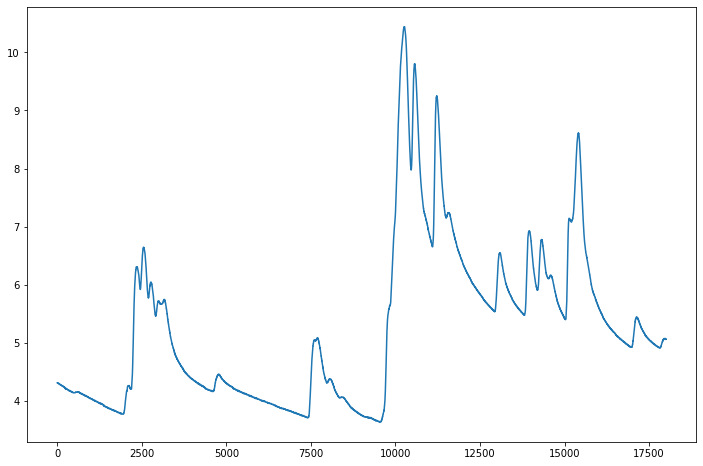

In [23]:
train_df.EDA.plot(figsize=(12, 8))

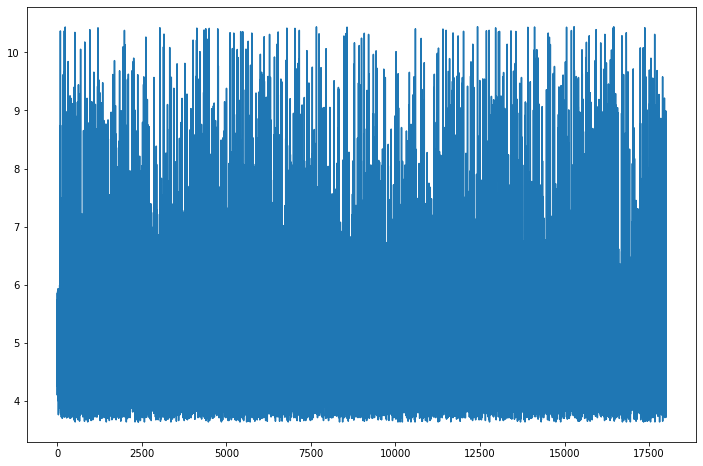

In [24]:
synthetic.EDA.plot(figsize=(12, 8))

In [27]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=2, cols=1)

fig.append_trace(go.Scatter(
    y=train_df['PERCLOS Value'],
    name='PERCLOS original',
), row=1, col=1)

fig.append_trace(go.Scatter(
    y=synthetic['PERCLOS Value'],
    name='PERCLOS synthetic',
), row=2, col=1)

fig.update_layout(height=500, width=1200, title_text="Individual channels")
fig.show()

In [28]:
fig = make_subplots(rows=2, cols=1)

fig.append_trace(go.Scatter(
    y=train_df.ECG,
    name='ECG original',
), row=1, col=1)

fig.append_trace(go.Scatter(
    y=synthetic.ECG,
    name='ECG synthetic',
), row=2, col=1)

fig.update_layout(height=500, width=1200, title_text="Individual channels")
fig.show()